# Perturbation Trasmission and Graph visualization


In [6]:
# Import necessary libraries
import networkx as nx  # For creating and manipulating graphs
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting
from matplotlib.patches import Patch  # For creating custom legend patches
import community.community_louvain as community_louvain

# Set the plotting style to 'ggplot'
plt.style.use('ggplot')


## SIRS model simulation

In [7]:
def dW(delta_t: float) -> float:
    """Sample a random number at each call."""
    return np.random.normal(loc=0.0, scale=np.sqrt(delta_t))

def Euler_Maruyama_method(parameters):
    """
    Perform Euler-Maruyama method to simulate an epidemiological model.

    Parameters:
    - parameters (dict): Dictionary containing model parameters.
        Expected keys:
        't_in': Start time of simulation.
        't_end': End time of simulation.
        'N': Number of time steps.
        'mu': Natural birth and death rate.
        'b0': Transmission parameter.
        'b1': Transmission parameter.
        'phi': Transmission parameter.
        'gamma': Recovery rate.
        'ni': Disease-induced death rate.
        'alpha': Scaling factor for stochastic term.
        'S_in': Initial susceptible population.
        'I_in': Initial infectious population.
        'R_in': Initial recovered population.

    Returns:
    - TS (numpy.ndarray): Array of time steps.
    - Ss (numpy.ndarray): Array of susceptible population over time.
    - Is (numpy.ndarray): Array of infectious population over time.
    - Rs (numpy.ndarray): Array of recovered population over time.
    """
    t_in = parameters['t_in']
    t_end = parameters['t_end']
    N = parameters['N']
    mu = parameters['mu']
    b0 = parameters['b0']
    b1 = parameters['b1']
    phi = parameters['phi']
    gamma = parameters['gamma']
    ni = parameters['ni']
    alpha = parameters['alpha']
    S_in = parameters['S_in']
    I_in = parameters['I_in']
    R_in = parameters['R_in']

    # Calculate time step size
    dt = float((t_end - t_in) / N)
    # Create array of time steps
    TS = np.arange(t_in, t_end + dt, dt)
    assert TS.size == N + 1

    # Initialize arrays for S, I, R populations
    Ss = np.zeros(TS.size)
    Is = np.zeros(TS.size)
    Rs = np.zeros(TS.size)

    # Set initial values
    Ss[0] = S_in
    Is[0] = I_in
    Rs[0] = R_in

    # Perform Euler-Maruyama method to simulate SIR model
    for i in range(1, TS.size):
        t = t_in + (i - 1) * dt
        S = Ss[i - 1]
        I = Is[i - 1]
        R = Rs[i - 1]

        # Calculate effective transmission rate with stochastic term
        b0_tilde = b0 + alpha * dW(dt)
        beta = b0_tilde * (1 + b1 * np.cos(2 * np.pi * t + phi))

        # Calculate stochastic term
        dW_dt = dW(dt)

        # Update S, I, R populations using differential equations
        Ss[i] = S + ((mu - mu * S - beta * S * I + gamma * R) * dt - (alpha / b0_tilde) * beta * S * I * dW_dt)
        Is[i] = I + ((beta * S * I - ni * I - mu * I) * dt - (alpha / b0_tilde) * beta * S * I * dW_dt)
        Rs[i] = R + (ni * I - mu * R - gamma * R) * dt

    return TS, Ss, Is, Rs

# Example parameters dictionary
parameters = {
    't_in': 0,
    't_end': 1,
    'N': 5000,
    'mu': 0.009,
    'b0': 36.4,
    'b1': 0.38,
    'phi': 1.07,
    'gamma': 1.8,
    'ni': 36,
    'alpha': 0.25,
    'S_in': 0.998,
    'I_in': 0.002,
    'R_in': 0.0
}

# Run simulation using Euler-Maruyama method
TS, Ss, Is, Rs = Euler_Maruyama_method(parameters)

# Calculate basic reproduction number R0
def calculate_R0(parameters):
    """
    Calculate the basic reproduction number R0 for an SIR-type epidemiological model.
    """
    mu = parameters['mu']
    gamma = parameters['gamma']
    ni = parameters['ni']
    beta = parameters['b0'] * parameters['phi'] * parameters['b1']
    R0 = beta / (mu + ni + gamma)
    return R0

# Calculate R0
R0 = calculate_R0(parameters)

# Print basic reproduction number (R0)
print(f"Basic Reproduction Number (R0): {round(R0, 1)}")

# Interpretation of R0
if round(R0) < 1:
    print("The infection will likely die out over time.")
elif round(R0) == 1:
    print("The infection will remain stable in the population but not cause an outbreak.")
else:
    print("The infection will likely spread and cause an epidemic.")

# Additional statistics
peak_infection = max(Is)
final_size = Ss[-1] + Is[-1] + Rs[-1]
print(f"Peak Infection: {peak_infection}")
print(f"Final Size of the Epidemic: {final_size}")


Basic Reproduction Number (R0): 0.4
The infection will likely die out over time.
Peak Infection: 0.0023842854233562484
Final Size of the Epidemic: 0.9993876482082806


### SIRS PLOTS

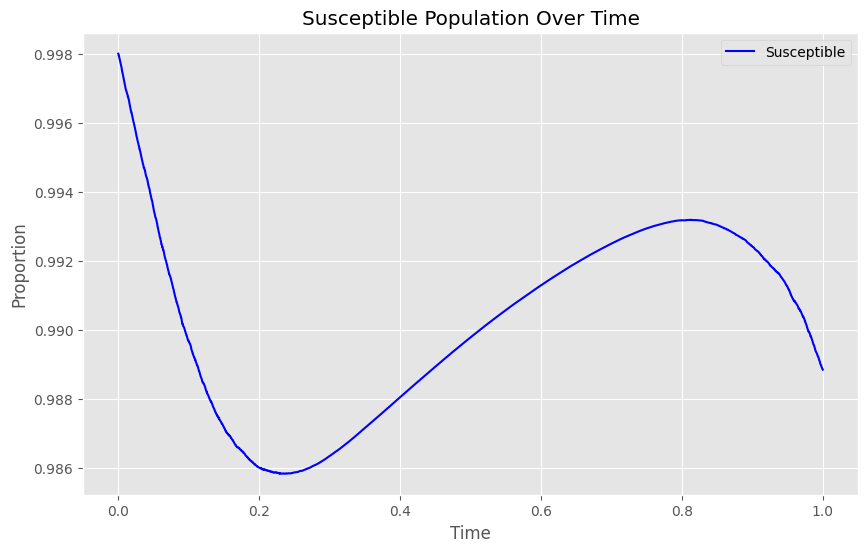

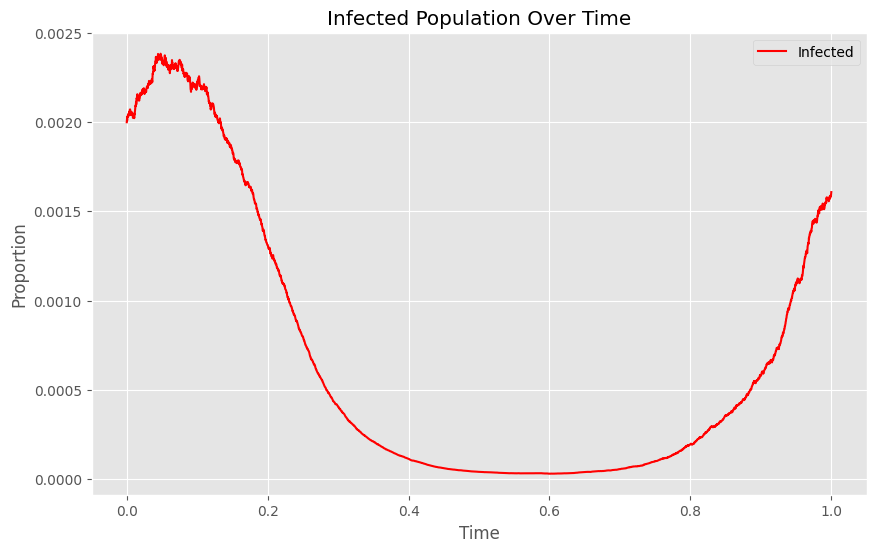

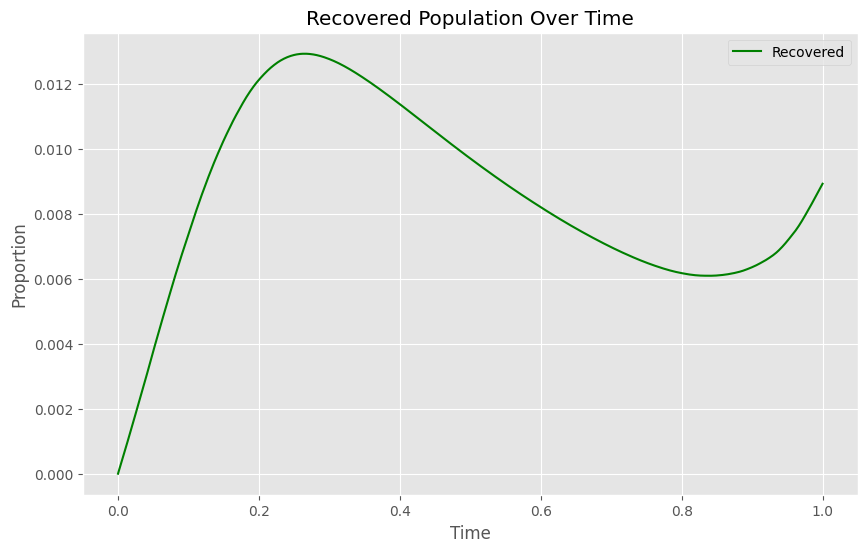

In [8]:
# Function to create a plot
def plot_population(TS, data, label, color):
    plt.figure(figsize=(10, 6))
    plt.plot(TS, data, label=label, color=color)
    plt.xlabel('Time')
    plt.ylabel('Proportion')
    plt.title(f'{label} Population Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot Susceptible over time
plot_population(TS, Ss, 'Susceptible', 'blue')

# Plot Infected over time
plot_population(TS, Is, 'Infected', 'red')

# Plot Recovered over time
plot_population(TS, Rs, 'Recovered', 'green')

# Plot all three (S, I, R) on the same graph
#plt.figure(figsize=(10, 6))
#plt.plot(TS, Ss, label='Susceptible', color='blue')
#plt.plot(TS, Is, label='Infected', color='red')
#plt.plot(TS, Rs, label='Recovered', color='green')
#plt.xlabel('Time')
#plt.ylabel('Proportion')
#plt.title('SIR Model Over Time')
#plt.legend()
#plt.grid(True)
#plt.show()


# NetworkX

## 1. Small-World Networks (Watts-Strogatz Model)

Small-world networks have high clustering like regular networks but also have short average path lengths between nodes. The Watts-Strogatz model can be used to generate small-world networks.

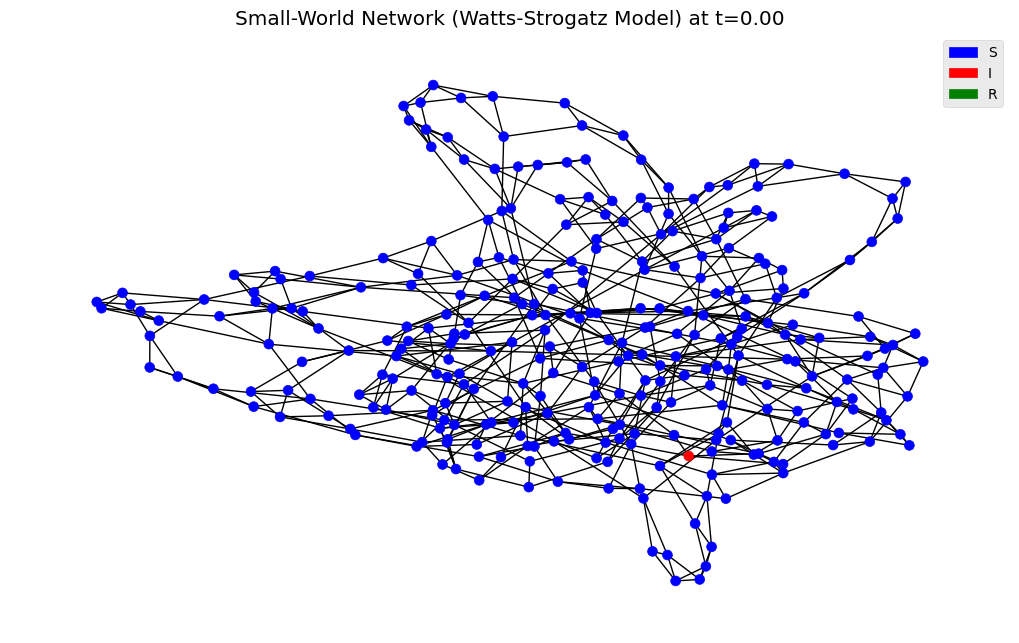

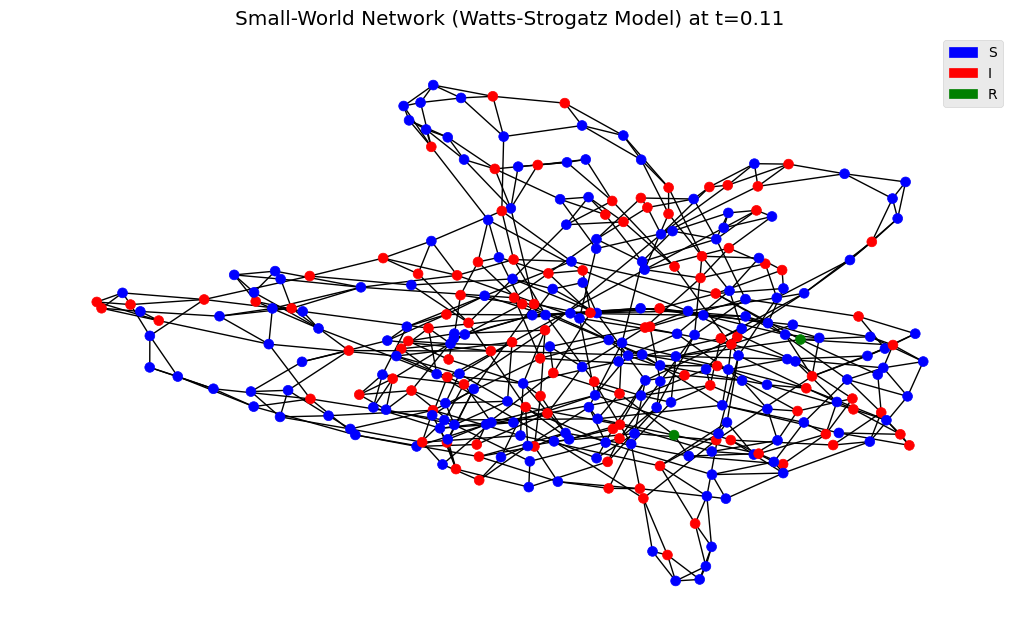

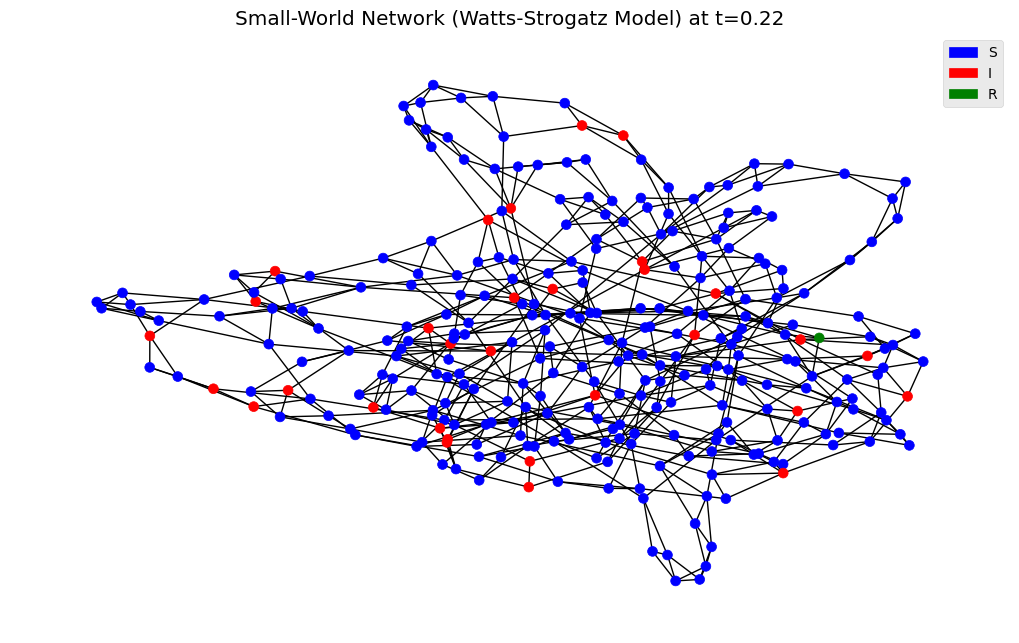

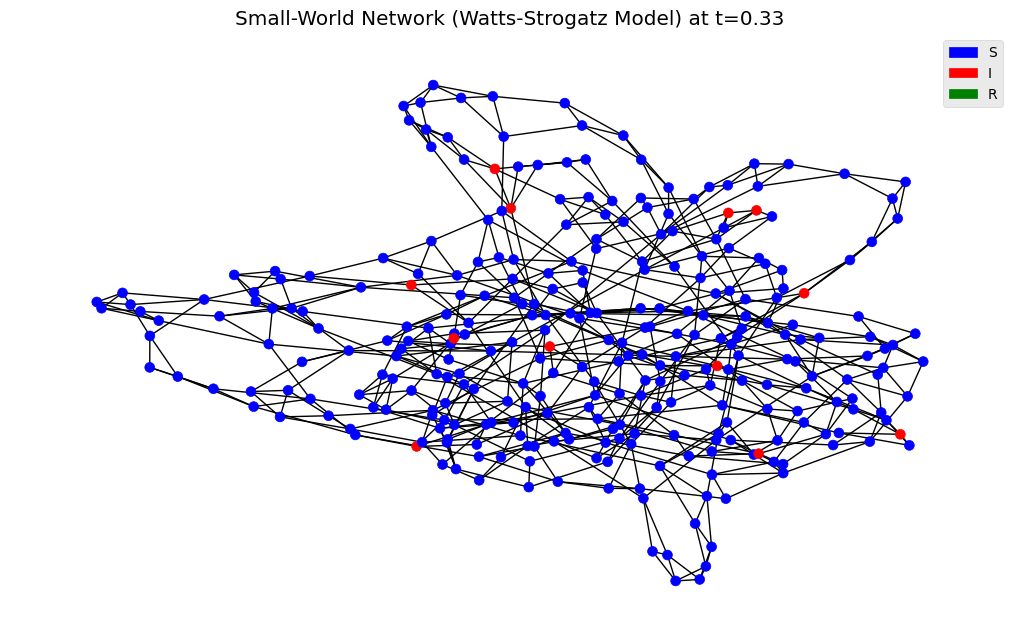

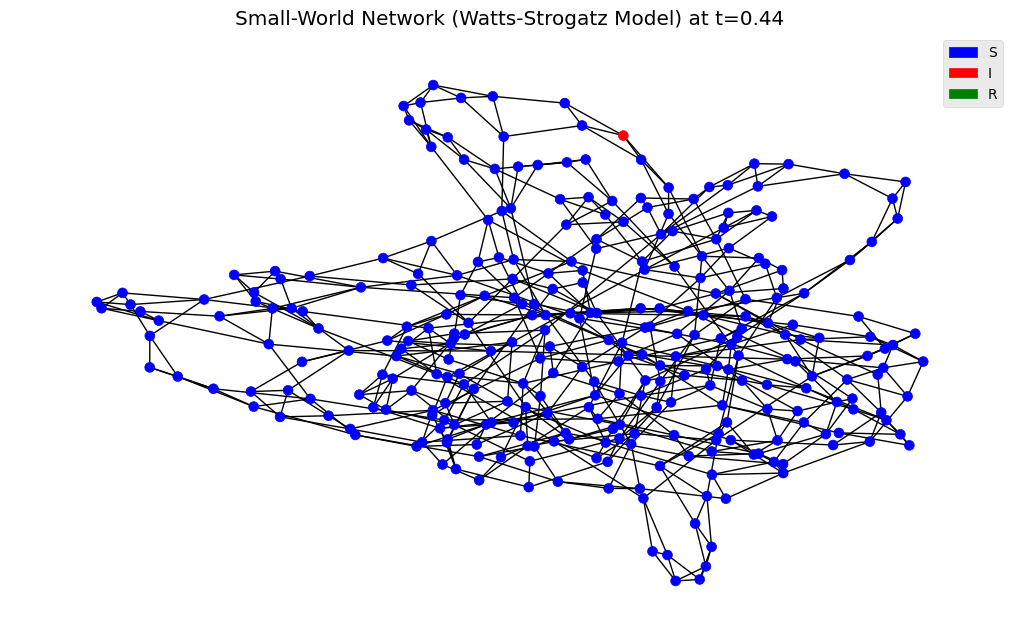

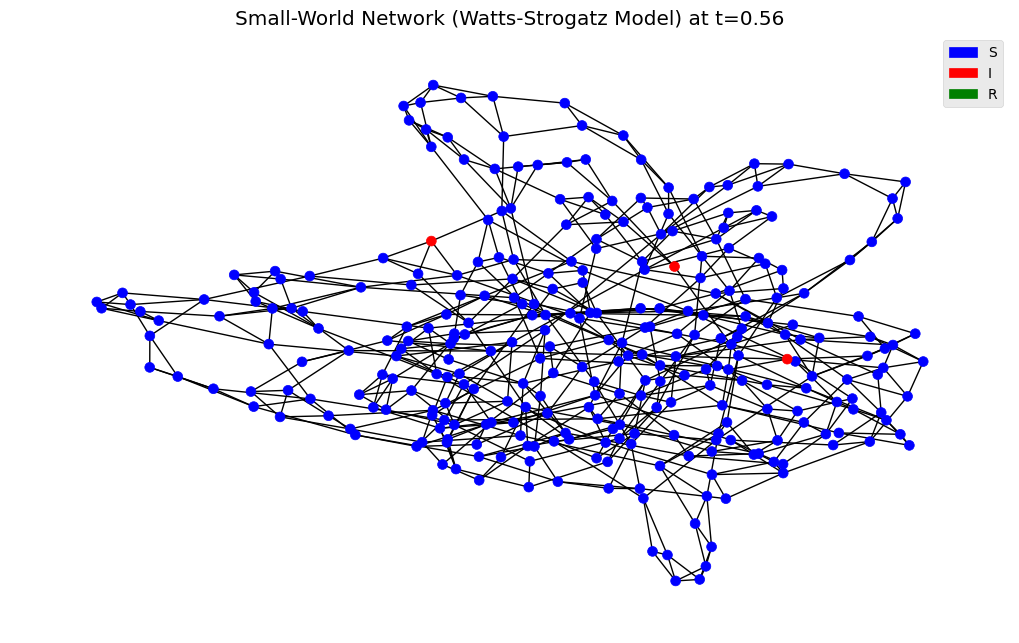

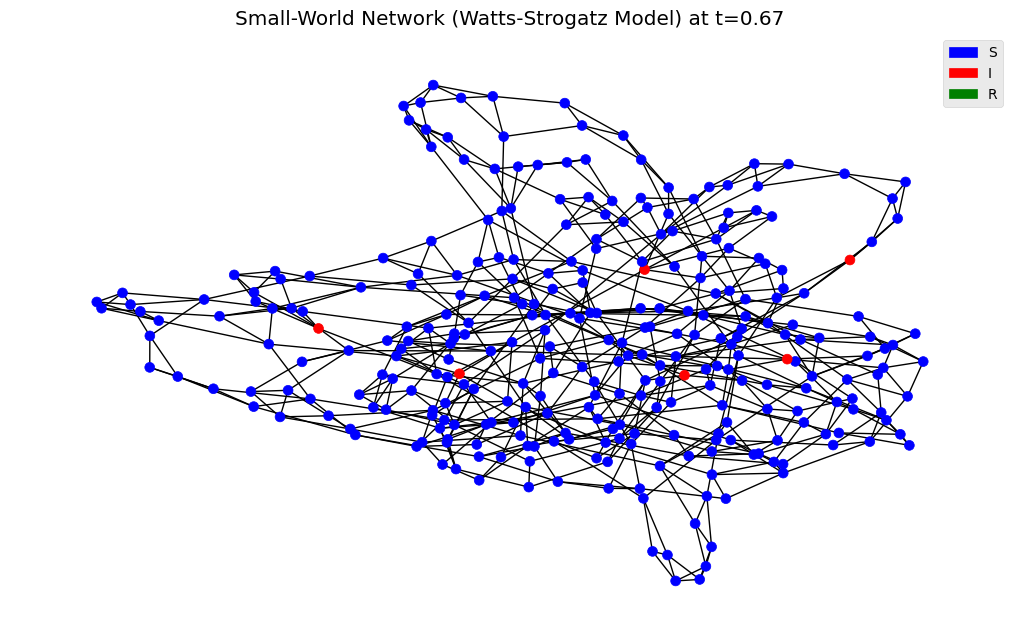

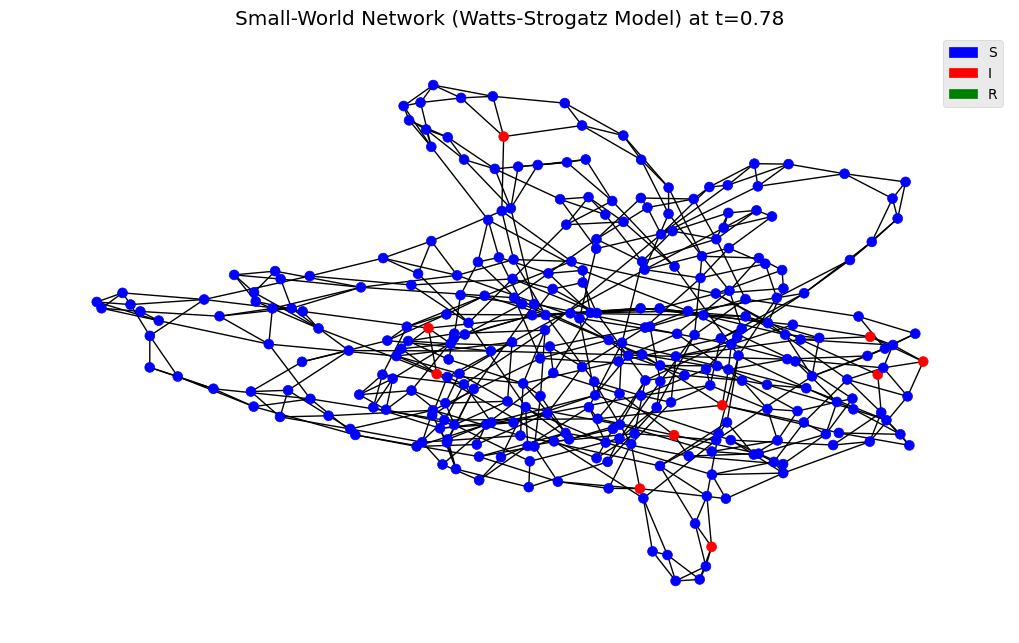

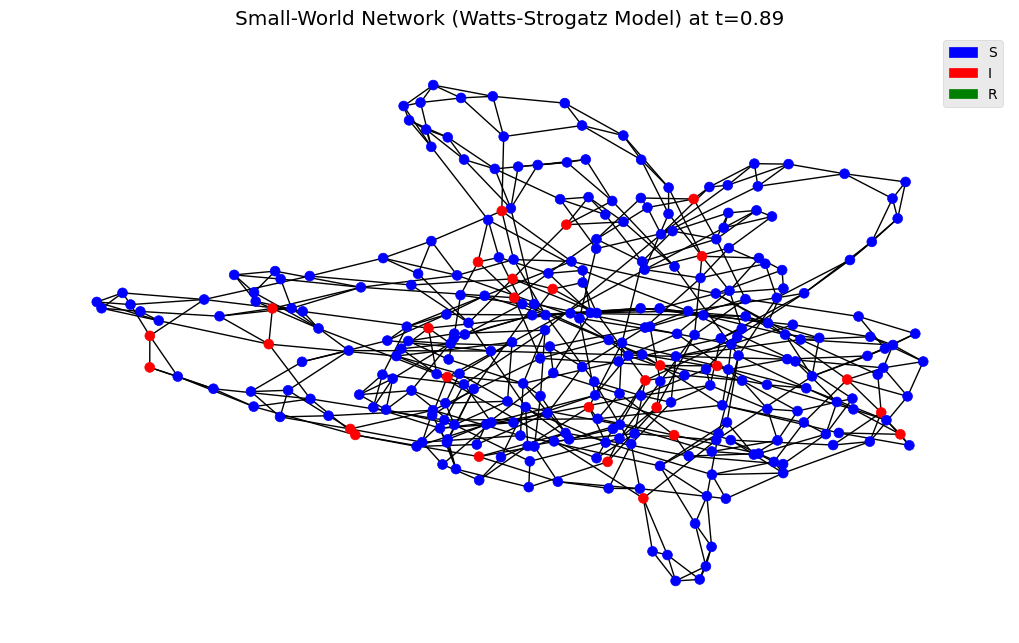

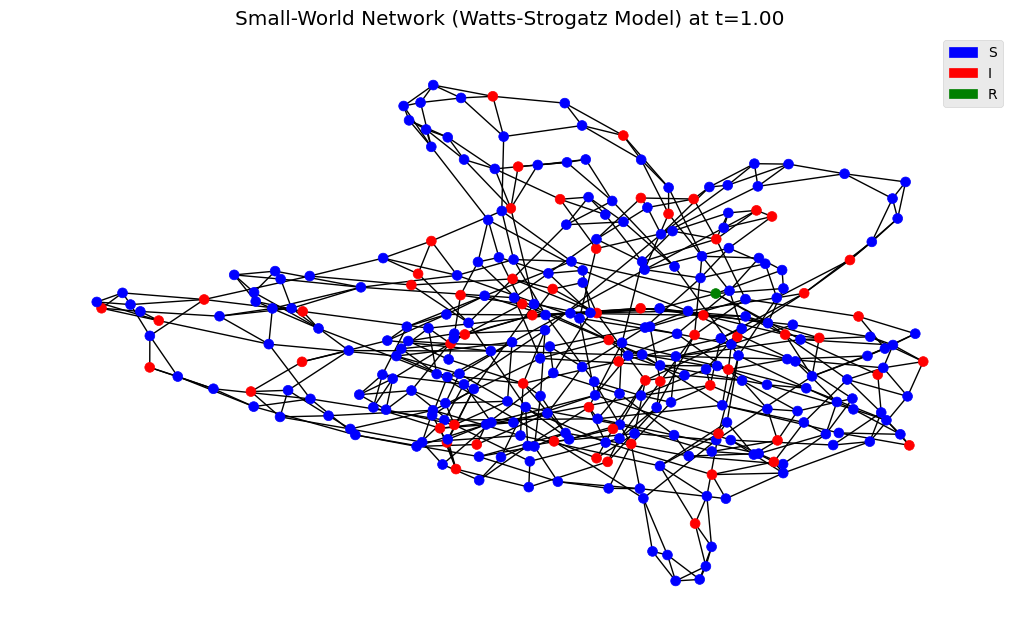

Effective Reproduction Number (Rt) at the beginning: 0.0013022154795595405


In [19]:
np.random.seed(42)

# Generate a Watts-Strogatz small-world network
n = 300
k = 4  # Each node is connected to k nearest neighbors
p = 0.15  # Probability of rewiring each edge
G = nx.watts_strogatz_graph(n, k, p)

# Ensure there is at least one initially infected node
initial_states = np.random.choice(['S', 'I', 'R'], size=len(G.nodes), p=[parameters['S_in'], parameters['I_in'], parameters['R_in']])
while not any(state == 'I' for state in initial_states):
    initial_states = np.random.choice(['S', 'I', 'R'], size=len(G.nodes), p=[parameters['S_in'], parameters['I_in'], parameters['R_in']])
nx.set_node_attributes(G, dict(zip(G.nodes, initial_states)), 'state')

# Define colors for each state and create a custom legend
state_colors = {'S': 'blue', 'I': 'red', 'R': 'green'}
legend_elements = [Patch(facecolor=color, edgecolor=color, label=state) for state, color in state_colors.items()]

# Fixed layout for consistent node positions in plots
pos = nx.spring_layout(G)

def update_states(G, t, Is, Rs, Ss):
    """
    Update the states of nodes in the Watts-Strogatz small-world network based on SIRS dynamics.

    Parameters:
    - G (networkx.Graph): Watts-Strogatz small-world network.
    - t (int): Current time step index.
    - Is (numpy.ndarray): Array of infectious population over time.
    - Rs (numpy.ndarray): Array of recovered population over time.
    - Ss (numpy.ndarray): Array of susceptible population over time.
    """
    for node in G.nodes:
        state = G.nodes[node]['state']
        neighbors = list(G.neighbors(node))
        
        # Check if any neighbor is infected ('I')
        neighbor_infected = any(G.nodes[neighbor]['state'] == 'I' for neighbor in neighbors)
        
        # Determine probabilities based on current state
        if state == 'S':
            # Susceptible node becomes infectious ('I') based on infection probability or due to infected neighbors
            infection_probability = Is[t] if not neighbor_infected else Is[t] * 2  # Increase probability if neighbors are infected
            if np.random.random() < infection_probability:
                G.nodes[node]['state'] = 'I'
        
        elif state == 'I':
            # Infectious node transitions to recovered ('R') based on recovery probability
            if np.random.random() < Rs[t]:
                G.nodes[node]['state'] = 'R'
        
        elif state == 'R':
            # Recovered node transitions back to susceptible ('S') based on susceptibility probability
            if np.random.random() < Ss[t]:
                G.nodes[node]['state'] = 'S'


# Euler-Maruyama method simulation
TS, Ss, Is, Rs = Euler_Maruyama_method(parameters)

# Determine plot intervals
plot_intervals = np.linspace(0, len(TS) - 1, 10).astype(int)

# Simulation and plotting
for t_index in plot_intervals:
    # Update node colors based on their states
    node_color = [state_colors[G.nodes[node]['state']] for node in G.nodes]

    # Draw the graph with updated node colors
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=False, node_color=node_color, node_size=50)
    plt.legend(handles=legend_elements, loc='best')
    plt.title(f'Small-World Network (Watts-Strogatz Model) at t={TS[t_index]:.2f}')
    plt.show()

    # Determine the range for the next state update
    next_t_index = plot_intervals[np.searchsorted(plot_intervals, t_index) + 1] if t_index != plot_intervals[-1] else len(TS)

    # Update states of nodes in the specified range
    for t in range(t_index, next_t_index):
        update_states(G, t, Is, Rs, Ss)

# Calculate effective reproduction number Rt over time
Rt = calculate_R0(parameters) * Ss / len(G.nodes)
print(f"Effective Reproduction Number (Rt) at the beginning: {Rt[0]}")

### Various metrics to analyze the graph's properties


--- Network Analysis Results ---

Average degree: 4.00
Average clustering coefficient: 0.3149
Average shortest path length: 6.03917502787068
Diameter: 12
Degree Assortativity: -0.0483
Global Efficiency: 0.1931
Local Efficiency: 0.4042

Degree Centrality (first 5 nodes):
Node 0: 0.0100
Node 1: 0.0134
Node 2: 0.0100
Node 3: 0.0134
Node 4: 0.0134

Betweenness Centrality (first 5 nodes):
Node 0: 0.0155
Node 1: 0.0141
Node 2: 0.0026
Node 3: 0.0110
Node 4: 0.0101


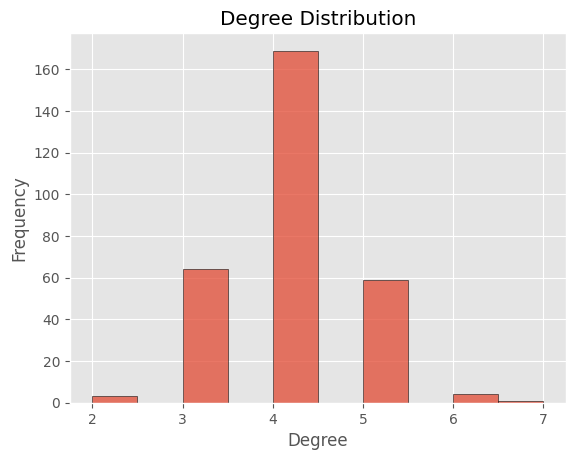

In [20]:
# Reset all rcParams to their default values
plt.rcdefaults()

# Degree distribution
degree_sequence = [d for n, d in G.degree()]

# Average degree
avg_degree = sum(degree_sequence) / len(degree_sequence)

# Clustering coefficient
avg_clustering = nx.average_clustering(G)

# Average shortest path length
try:
    avg_shortest_path_length = nx.average_shortest_path_length(G)
except nx.NetworkXError:
    avg_shortest_path_length = "Graph is not connected."

# Diameter (may need to handle exceptions if graph is not connected)
try:
    diameter = nx.diameter(G)
except nx.NetworkXError:
    diameter = "Graph is not connected."

# Degree centrality
degree_centrality = nx.degree_centrality(G)

# Betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)

# Assortativity
assortativity = nx.degree_assortativity_coefficient(G)

# Global efficiency
global_efficiency = nx.global_efficiency(G)

# Local efficiency
local_efficiency = nx.local_efficiency(G)

# Printing the results
print("\n--- Network Analysis Results ---\n")
print(f"Average degree: {avg_degree:.2f}")
print(f"Average clustering coefficient: {avg_clustering:.4f}")
print(f"Average shortest path length: {avg_shortest_path_length}")
print(f"Diameter: {diameter}")
print(f"Degree Assortativity: {assortativity:.4f}")
print(f"Global Efficiency: {global_efficiency:.4f}")
print(f"Local Efficiency: {local_efficiency:.4f}")

# Degree centrality (print for first few nodes)
print("\nDegree Centrality (first 5 nodes):")
for node in list(G.nodes())[:5]:
    print(f"Node {node}: {degree_centrality[node]:.4f}")

# Betweenness centrality (print for first few nodes)
print("\nBetweenness Centrality (first 5 nodes):")
for node in list(G.nodes())[:5]:
    print(f"Node {node}: {betweenness_centrality[node]:.4f}")

# Degree histogram
#plt.figure(figsize=(10, 6))
plt.style.use('ggplot')
plt.hist(degree_sequence, bins='auto', alpha=0.75, edgecolor='black')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution')
plt.grid(True)
plt.show()


## Community detection
Community detection is a process in network analysis aimed at identifying clusters or groups of nodes that are more densely connected to each other than to the rest of the network. The Louvain method is one of the most popular algorithms for community detection due to its efficiency and effectiveness.
It is designed to optimize modularity, a measure that quantifies the strength of division of a network into communities. High modularity indicates dense connections within communities and sparse connections between communities.

### Steps of the Louvain Method

* Initialization: Each node in the network starts in its own community.

* Local Optimization: For each node, the algorithm evaluates the gain in modularity that would result from moving the node to the community of each of its neighbors. The node is then placed into the community that results in the highest gain in modularity, provided this gain is positive. This process is repeated iteratively for all nodes until no further improvement can be achieved.

* Aggregation: The network is aggregated into a new network where each community from the previous step is represented as a single node. Edges between these new nodes are weighted by the sum of the weights of the edges between the original communities.

* Repetition: The local optimization process is applied again to this new aggregated network. Steps 2 and 3 are repeated iteratively until the modularity cannot be improved further.

### Benefits of the Louvain Method

* Efficiency: The method is computationally efficient, making it suitable for large networks.

* Scalability: It can handle networks with millions of nodes and edges.

* Quality: It generally produces high-quality partitions that optimize modularity well.

Number of communities detected: 14
Modularity: 0.7759236111111112


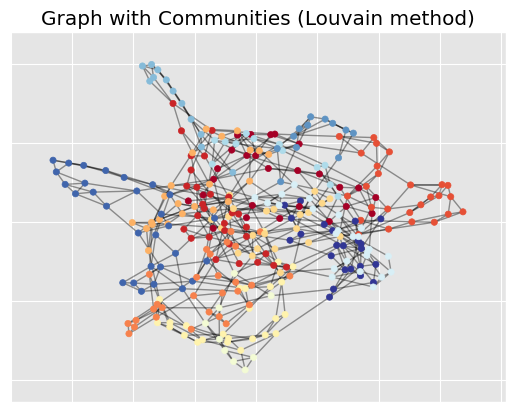

In [21]:
# Community detection using Louvain method
partition = community_louvain.best_partition(G)
print(f"Number of communities detected: {len(set(partition.values()))}")

# Modularity
modularity = community_louvain.modularity(partition, G)
print(f"Modularity: {modularity}")

# Visualization of communities
pos = nx.spring_layout(G)
#plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_size=20, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.4)
plt.title('Graph with Communities (Louvain method)')
plt.show()

## 2. Random graph (Erdős-Rényi)

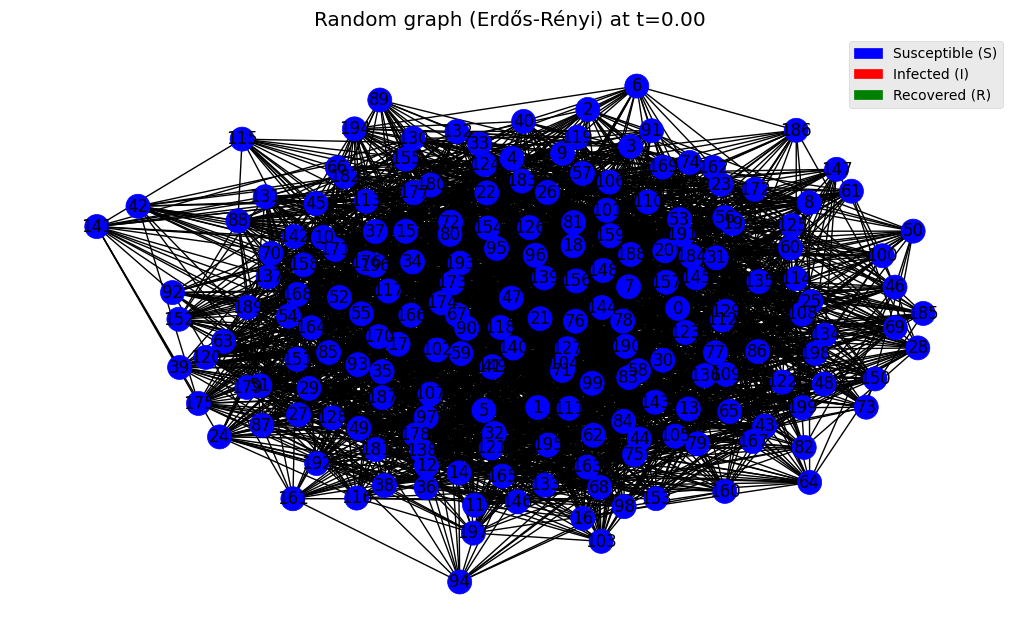

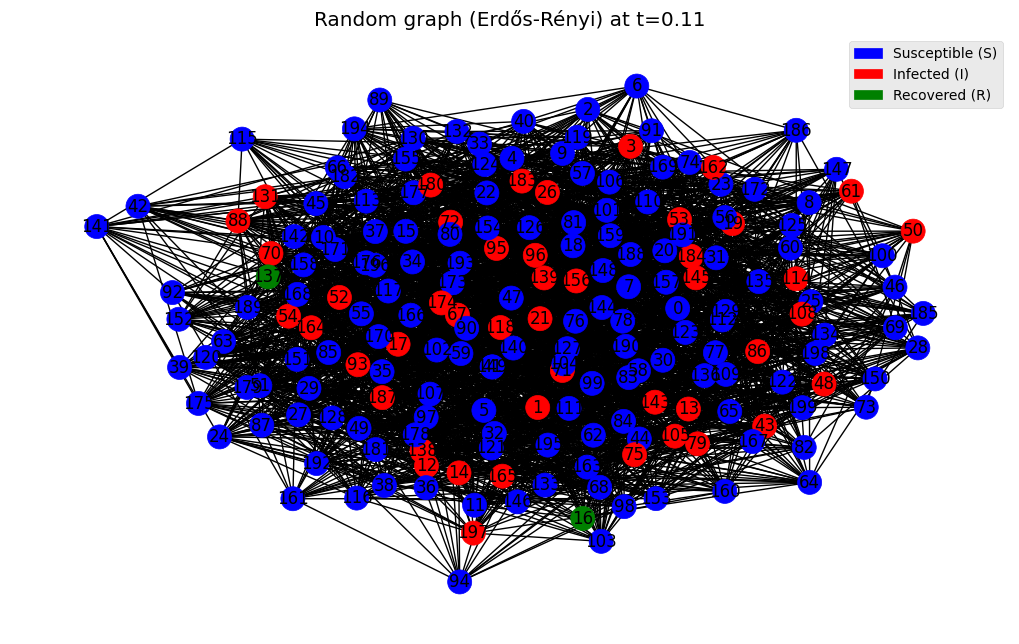

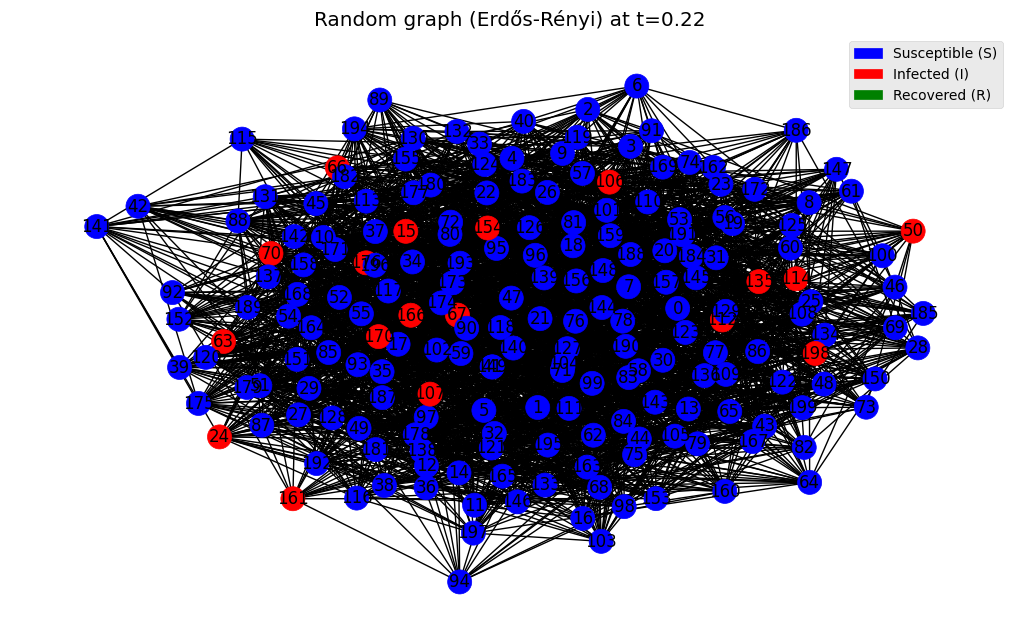

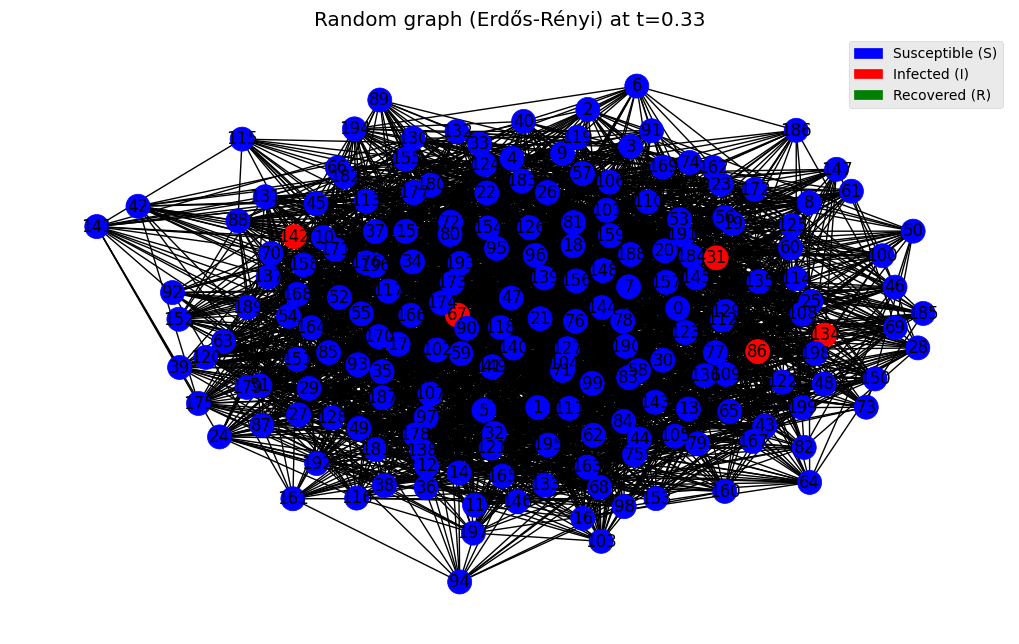

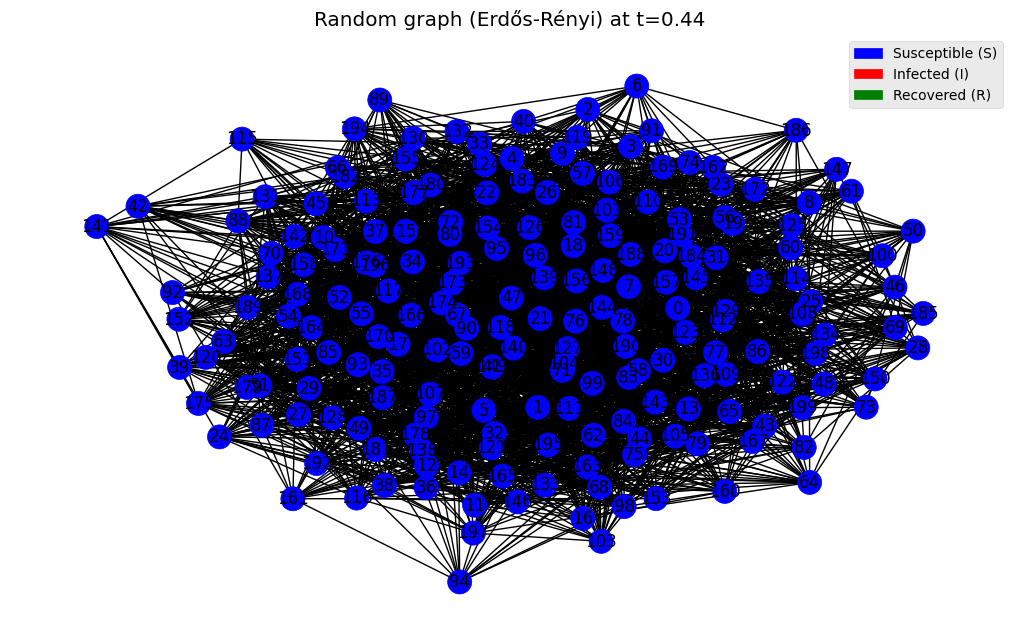

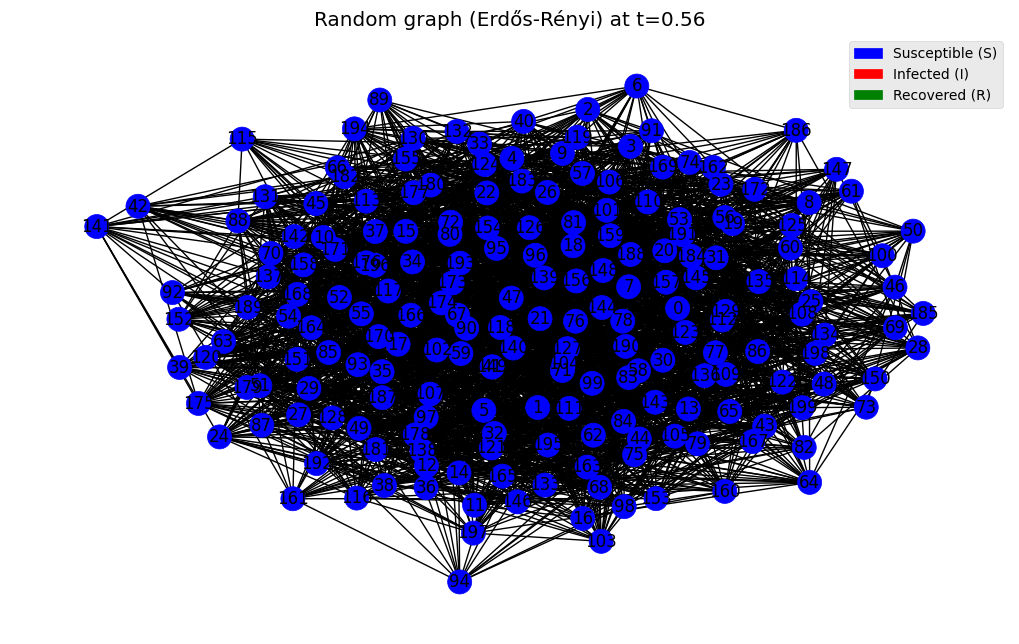

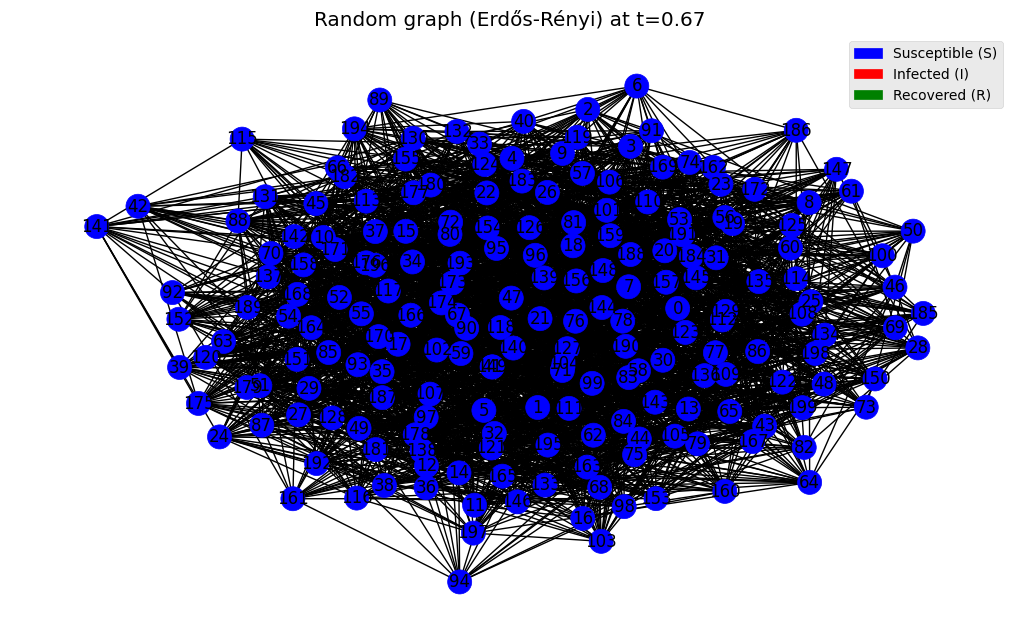

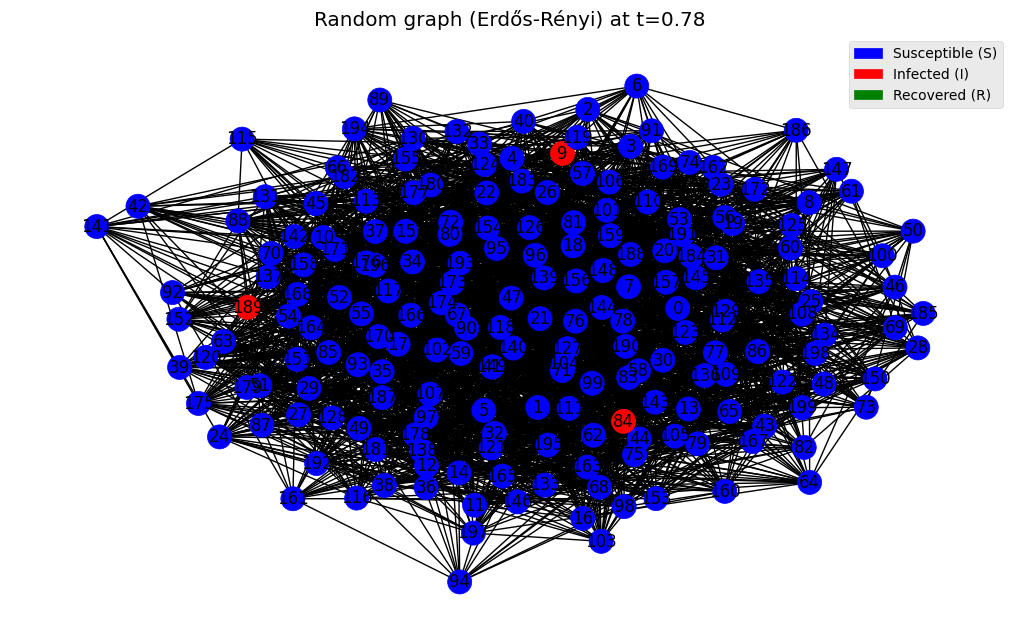

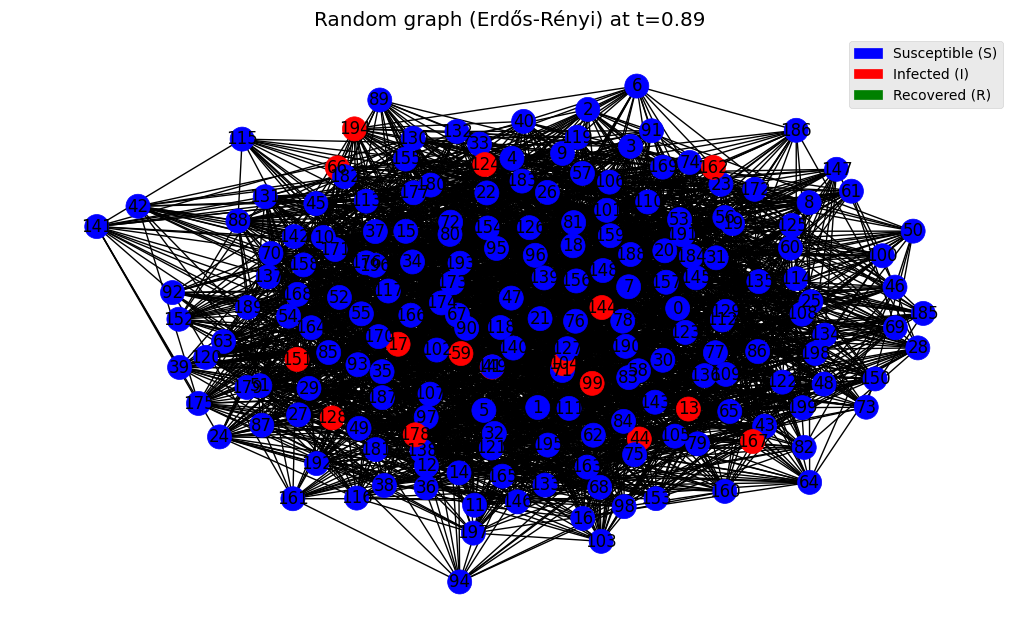

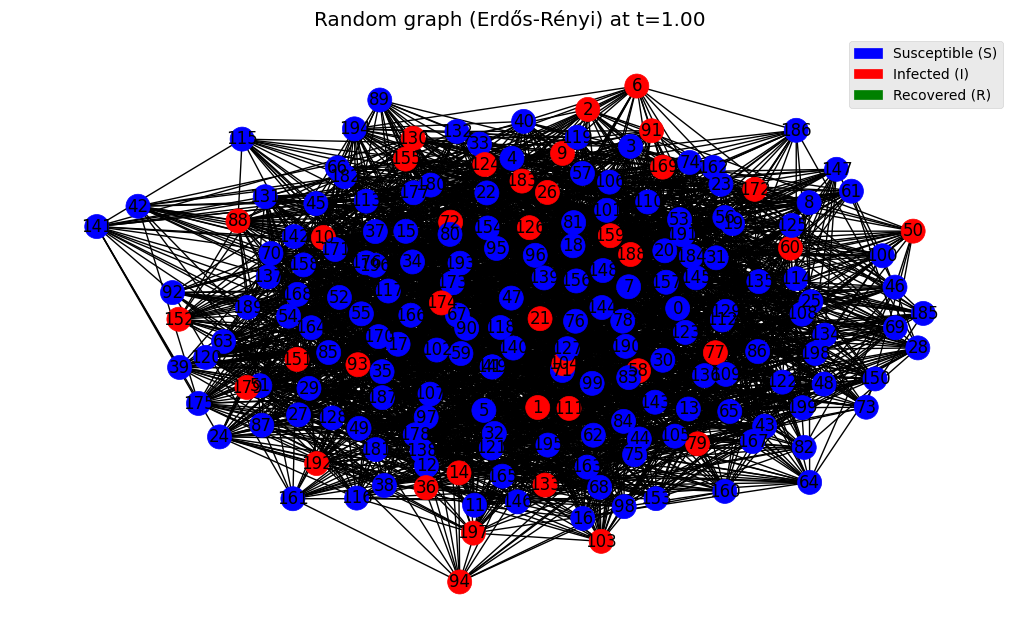

Effective Reproduction Number (Rt) at the beginning: 0.3906646438678622


In [24]:
# Set random seed for reproducibility
np.random.seed(42)

# Create an Erdős-Rényi random graph
G = nx.erdos_renyi_graph(n=200, p=0.15)  # n: number of nodes, p: probability of edge creation

# Assign initial states to nodes based on S_in, I_in, R_in
initial_states = np.random.choice(['S', 'I', 'R'], size=len(G.nodes), p=[parameters['S_in'], parameters['I_in'], parameters['R_in']])
for node, state in zip(G.nodes, initial_states):
    G.nodes[node]['state'] = state

# Simulate SIRS dynamics on the graph using Euler-Maruyama method
TS, Ss, Is, Rs = Euler_Maruyama_method(parameters)

# Fixed layout for all iterations using spring layout
pos = nx.spring_layout(G)

# Determine the indices of the time points to plot
plot_intervals = np.linspace(0, len(TS) - 1, 10).astype(int)

# Define colors for each state
node_colors = {'S': 'blue', 'I': 'red', 'R': 'green'}

# Create custom legend for node states
legend_elements = [
    Patch(facecolor='blue', edgecolor='blue', label='Susceptible (S)'),
    Patch(facecolor='red', edgecolor='red', label='Infected (I)'),
    Patch(facecolor='green', edgecolor='green', label='Recovered (R)')
]

# Iterate over selected time points for plotting
for t_index in plot_intervals:
    # Update node colors based on their current state at time t_index
    node_color = [node_colors[G.nodes[node]['state']] for node in G.nodes]

    # Draw the graph with updated node colors and legend
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, node_color=node_color)
    plt.legend(handles=legend_elements, loc='best')
    plt.title(f'Random graph (Erdős-Rényi) at t={TS[t_index]:.2f}')
    plt.show()

    # Update states of nodes based on SIRS simulation results up to the next plot interval
    for t in range(t_index, len(TS) if t_index == plot_intervals[-1] else plot_intervals[plot_intervals.tolist().index(t_index) + 1]):
        for node in G.nodes:
            if G.nodes[node]['state'] == 'S':
                # Transition from susceptible to infected based on infection probability Is[t]
                if np.random.random() < Is[t]:
                    G.nodes[node]['state'] = 'I'
            elif G.nodes[node]['state'] == 'I':
                # Transition from infected to recovered based on recovery probability Rs[t]
                if np.random.random() < Rs[t]:
                    G.nodes[node]['state'] = 'R'
            elif G.nodes[node]['state'] == 'R':
                # Transition from recovered back to susceptible based on loss of immunity probability Ss[t]
                if np.random.random() < Ss[t]:
                    G.nodes[node]['state'] = 'S'

# Calculate effective reproduction number Rt over time
Rt = parameters['b0'] * parameters['phi'] * parameters['b1'] * Ss / (parameters['mu'] + parameters['ni'] + parameters['gamma'])

# Print initial effective reproduction number (Rt) at the beginning
print(f"Effective Reproduction Number (Rt) at the beginning: {Rt[0]}")
